In [5]:
import sys
import os
# define directory to packages and append to $PATH
par_dir = "/home/laser/hpsim"
print(par_dir)
lib_dir = os.path.join(par_dir,"bin")
print(lib_dir)
sys.path.append(lib_dir)
pkg_dir = os.path.join(par_dir,"pylib")
print(pkg_dir)
sys.path.append(pkg_dir)
import copy

/home/laser/hpsim
/home/laser/hpsim/bin
/home/laser/hpsim/pylib


In [6]:
#import additional python packages
import numpy as np
import matplotlib.pyplot as plt
#import matplotlib.mlab as mlab
import math
# import additional simulation packages
import hpsim as hps
import HPSim as HPSim
# use next line to select either GPU 0 or 2 on aothpsim
GPU = 0
hps.set_gpu(GPU)
import lcsutil as lcs
import nputil as npu
import sqldb as pydb
import time

In [7]:
# install db's and connect to beamline
db_dir = par_dir + '/db/'
lib_dir = par_dir + '/db/lib/'
# dbs = ['tbtd.db','dtl.db','trst.db','ccl.db']
dbs = ['clapa1.db']
dbconn1 = hps.DBConnection(db_dir, dbs, lib_dir, 'libsqliteext')
dbconn1.print_libs()
dbconn1.print_dbs()
dbconn1.clear_model_index()
print("*** dB connection established ***\n")

*** dB connection established ***



In [8]:
# create beamline
bl = hps.BeamLine()
beamline = hps.get_element_list()
print("*** Beamline created ***\n")

*** Beamline created ***



In [9]:
beamline

['drift1',
 'engeQ1_1',
 'Q1',
 'engeQ1_2',
 'engeQ2_1',
 'Q2',
 'enegQ2_2',
 'enegQ3_1',
 'Q3',
 'enegQ3_2',
 'drift2']

In [10]:
hps.get_beamline_length('drift1','drift2')

2.696

In [11]:
for name in beamline:
    print(hps.get_db_model(name, "model_type"))

drift
drift
quad
drift
drift
quad
drift
drift
quad
drift
drift


In [12]:
# create H- beam
SIM_START = "drift1" #defined by input beam location
#beam = hps.Beam(mass=939.294, charge=-1.0, current=0.015, num=1024*256) #H- beam
beam = hps.Beam(mass=939.294, charge=1.0, current=0.015, num=1024*16) #H- beam
# beam.set_dc(0.095, 47.0, 0.00327,  -0.102, 60.0, 0.002514, 10, 0, 4.611) #TBDB02 20140901
beam.set_waterbag(0, 0.01, 0.000015,0, 0.01, 0.000015,0, 65.430429, 0.05633529, 0, 4.611, 500, random_seed = 0)
beam.set_frequency(500)
betalambda = hps.betalambda(mass = beam.get_mass(), freq=beam.get_frequency(), w=0.750)
phi_offset = -hps.get_beamline_length(SIM_START,'drift2')/betalambda *360
# phi_offset = 180
beam.set_ref_w(4.611)
beam.set_ref_phi(0)
# beam.translate('phi', phi_offset)
beam.save_initial_beam()
# beam.restore_initial_beam()
print("*** H- Beam created ***\n")

mask = beam.get_good_mask()
start_beam = beam

print("The index of SIM_START %s is %d"%(SIM_START, beamline.index(SIM_START)))
print("length:", hps.get_element_length(SIM_START))
print("view index:", hps.get_db_model(SIM_START, "view_index"))
print("model index:", hps.get_db_model(SIM_START, "model_index"))

*** H- Beam created ***

The index of SIM_START drift1 is 0
('length:', 0.16)
('view index:', 1.0)
('model index:', 0.0)


 4 x  3 BeamPlot object created


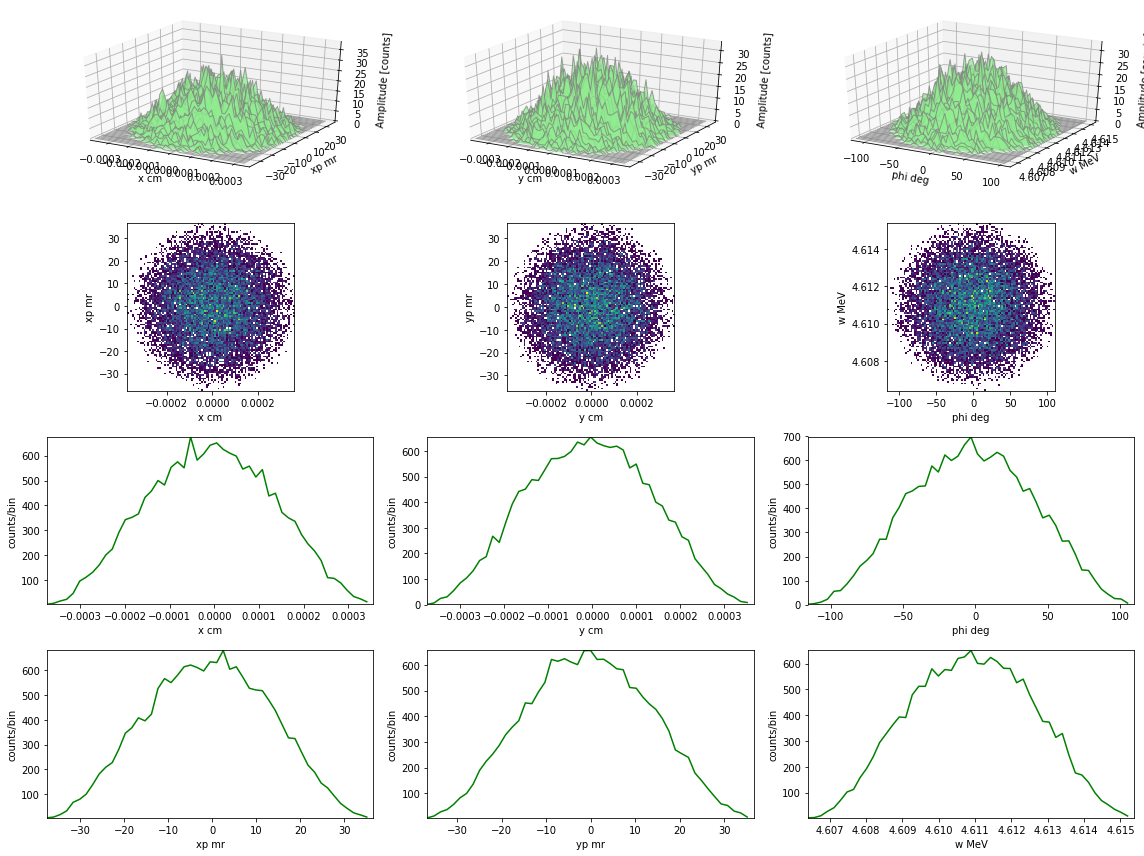

In [13]:
plot = hps.BeamPlot(nrow=4, ncol=3, hsize=16, vsize=12)
plot.title(SIM_START)
plot.iso_phase_space('xxp', beam, mask, 1)
plot.iso_phase_space('yyp', beam, mask, 2)
plot.iso_phase_space('phiw', beam, mask, 3 )
plot.hist2d_phase_space('xxp', beam, mask, 4)
plot.hist2d_phase_space('yyp', beam, mask, 5)
plot.hist2d_phase_space('phiw', beam, mask, 6)
plot.profile('x', beam, mask, 7, 'g-')
plot.profile('y', beam, mask, 8, 'g-')
plot.profile('phi', beam, mask, 9, 'g-')
plot.profile('xp', beam, mask, 10, 'g-')
plot.profile('yp', beam, mask, 11, 'g-')
plot.profile('w', beam, mask, 12, 'g-')
plot.show()

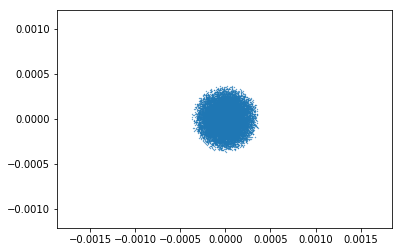

In [14]:
x = beam.get_coor('x', None)
y = beam.get_coor('y', None)
plt.scatter(x,y, s=0.1)
plt.axis('equal')
plt.show()

In [15]:
# create spacecharge
spch = hps.SpaceCharge(nr = 32, nz = 128, interval = 0.025, adj_bunch = 3)
print("spch interval=", spch.get_interval())
print("adj_bunch=", spch.get_adj_bunch())
# define at what energy simulation stops using adjacent bunches in SC calc
spch.set_adj_bunch_cutoff_w(0.8)
# remeshing factor determines how ofter the mesh gets recalc vs scaled for SC kick
spch.set_remesh_threshold(0.02)
#spch.set_remesh_threshold(0.2)
print( "cutoff w=", spch.get_adj_bunch_cutoff_w())
print( "*** Space Charge Initialized ***\n")

('spch interval=', 0.025)
('adj_bunch=', 3)
('cutoff w=', 0.8)
*** Space Charge Initialized ***



In [16]:
# create simulator
sim = hps.Simulator(beam)
sim.set_space_charge('off')
print( "*** Simulator Initialized ***\n")

*** Simulator Initialized ***



In [22]:
SIM_STOP = 'drift2'
print("The index of SIM_STOP %s is %d"%(SIM_STOP, beamline.index(SIM_STOP)))
print("length:", hps.get_element_length(SIM_STOP))
print("view index:", hps.get_db_model(SIM_STOP, "view_index"))
print("model index:", hps.get_db_model(SIM_STOP, "model_index"))

ENERGY_CUTOFF = 0.0
mask = gmask = beam.get_good_mask()

print( "*** Input Beam ***")
print( SIM_START)
print( "w/user units")
beam.print_results()

print( "*** Starting Simulation ***\n")
start_time = time.time()
sim.simulate(SIM_START, SIM_STOP)
print("Simulation time: %f s"%(time.time()-start_time))

# determine mask of particles used in analysis and plotting
wmask = beam.get_mask_with_limits('w', lolim = ENERGY_CUTOFF)
gmask = beam.get_good_mask(wmask)
mask = gmask

print( "*** Output Beam ***")
print( SIM_STOP)
print( "w/user units")
beam.print_results()

The index of SIM_STOP drift2 is 10
('length:', 1.96)
('view index:', 11.0)
('model index:', 10.0)
*** Input Beam ***
drift1
w/user units
Distribution Analysis Results (w/user units)
Mass = 939.2940
Charge/|e| = 1
Ib = 0.72 mA
Frequency = 500.000 MHz
*** No Mask applied ***
Number of macroparticles(good) = 781
Number of macroparticles lost  = 15603
Ref part. 
 phi = 65586.4764 deg
   w =     4.6110 MeV

Centroids and RMS sizes
            Avg         Sigma
x  :      -0.0026        1.1410 cm 
xp :      -0.1060       18.9249 mr 
y  :       0.0383        2.6488 cm 
yp :       0.8910       64.9401 mr 
phi:   44026.5107     9343.8885 deg
w  :       4.6110        0.0017 MeV

Twiss parameters
          Alpha       Beta       Eurms       Enrms
x :      1.7847      0.1233     10.5547     1.04711
y :     -3.3010      0.1407     49.8716     4.94763
z :     -0.0205 5599996.3964     15.5908


*** Starting Simulation ***

Simulation time: 0.005677 s
*** Output Beam ***
drift2
w/user units
Distributio

In [ ]:
# create output plot
import matplotlib.pyplot as plt

# mask = None
plot = hps.BeamPlot(nrow=4, ncol=3, hsize=16, vsize=12)
plot.title(SIM_STOP)
plot.iso_phase_space('xxp', beam, mask, 1)
plot.iso_phase_space('yyp', beam, mask, 2)
plot.iso_phase_space('phiw', beam, mask, 3 )
plot.hist2d_phase_space('xxp', beam, mask, 4)
plot.hist2d_phase_space('yyp', beam, mask, 5)
plot.hist2d_phase_space('phiw', beam, mask, 6)
plot.profile('x', beam, mask, 7, 'g-')
plot.profile('y', beam, mask, 8, 'g-')
plot.profile('phi', beam, mask, 9, 'g-')
plot.profile('xp', beam, mask, 10, 'g-')
plot.profile('yp', beam, mask, 11, 'g-')
plot.profile('w', beam, mask, 12, 'g-')
plot.show()

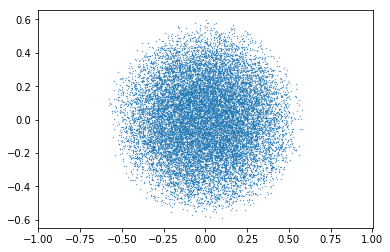

In [11]:
x = beam.get_coor('x', mask)
y = beam.get_coor('y', mask)
plt.scatter(x,y, s=0.1)
plt.axis('equal')
plt.show()

# 分段运行模拟，和一次性模拟对比

*** H- beam2 created ***

 4 x  3 BeamPlot object created


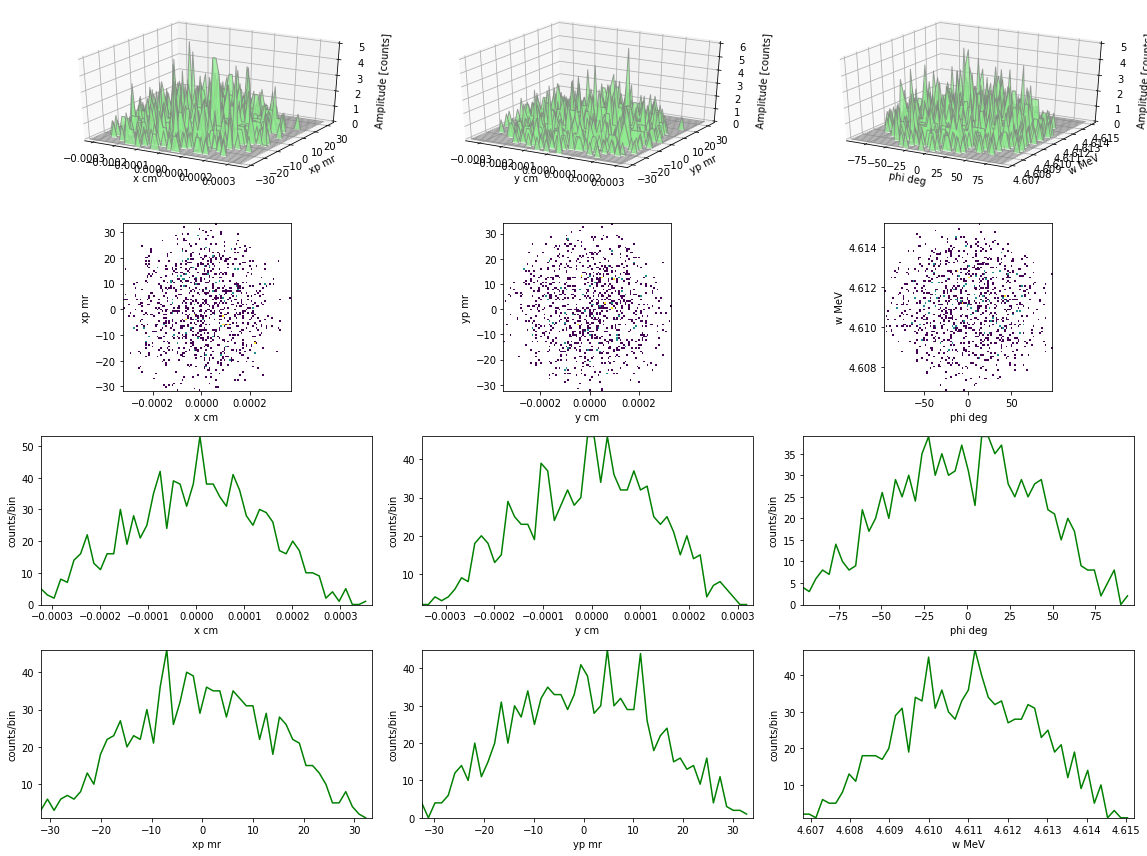

In [6]:
# create H- beam2
SIM_START = "drift1" #defined by input beam2 location
#beam2 = hps.Beam(mass=939.294, charge=-1.0, current=0.015, num=1024*256) #H- beam2
beam2 = hps.Beam(mass=939.294, charge=1.0, current=0.015, num=1024) #H- beam2
beam2.set_waterbag(0, 0.01, 0.000015,0, 0.01, 0.000015,0, 65.430429, 0.05633529, 0, 4.611, 500, random_seed = 0)
beam2.set_frequency(500)
betalambda = hps.betalambda(mass = beam2.get_mass(), freq=beam2.get_frequency(), w=0.750)
phi_offset = -hps.get_beamline_length(SIM_START,'drift2')/betalambda *360
# phi_offset = 180
beam2.set_ref_w(4.611)
beam2.set_ref_phi(0)
# beam2.restore_initial_beam()
print("*** H- beam2 created ***\n")

mask = beam2.get_good_mask()
start_beam2 = beam2

plot = hps.BeamPlot(nrow=4, ncol=3, hsize=16, vsize=12)
plot.title(SIM_START)
plot.iso_phase_space('xxp', beam2, mask, 1)
plot.iso_phase_space('yyp', beam2, mask, 2)
plot.iso_phase_space('phiw', beam2, mask, 3 )
plot.hist2d_phase_space('xxp', beam2, mask, 4)
plot.hist2d_phase_space('yyp', beam2, mask, 5)
plot.hist2d_phase_space('phiw', beam2, mask, 6)
plot.profile('x', beam2, mask, 7, 'g-')
plot.profile('y', beam2, mask, 8, 'g-')
plot.profile('phi', beam2, mask, 9, 'g-')
plot.profile('xp', beam2, mask, 10, 'g-')
plot.profile('yp', beam2, mask, 11, 'g-')
plot.profile('w', beam2, mask, 12, 'g-')
plot.show()

In [7]:
# create spacecharge
spch = hps.SpaceCharge(nr = 32, nz = 128, interval = 0.025, adj_bunch = 3)
print("spch interval=", spch.get_interval())
print("adj_bunch=", spch.get_adj_bunch())
# define at what energy simulation stops using adjacent bunches in SC calc
spch.set_adj_bunch_cutoff_w(0.8)
# remeshing factor determines how ofter the mesh gets recalc vs scaled for SC kick
spch.set_remesh_threshold(0.02)
#spch.set_remesh_threshold(0.2)
print( "cutoff w=", spch.get_adj_bunch_cutoff_w())
print( "*** Space Charge Initialized ***\n")

('spch interval=', 0.025)
('adj_bunch=', 3)
('cutoff w=', 0.8)
*** Space Charge Initialized ***



In [ ]:
def simulate_with_envelope(beam, start_node, end_node, space_charge="off"):
    start_index = hps.get_db_model(start_node, "model_index")
    end_index = hps.get_db_model(end_node, "model_index")
    beamline = hps.get_element_list()[int(start_index): int(end_index) + 1]
    
    simulator = hps.Simulator(beam)
    simulator.set_space_charge(space_charge)
    
    z = np.array([0])
    avg_x = np.array([ beam.get_avg('x') ])
    avg_y = np.array([ beam.get_avg('y') ])
    sig_x = np.array([ beam.get_sig('x') ])
    sig_y = np.array([ beam.get_sig('y') ])
    
    print( "*** Starting Simulation ***\n")
    start_time = time.time()
    
    i = 1
    for node in beamline[:1]:
        simulator.simulate(node, node)
        
#         z = np.append(z, z[-1] + hps.get_element_length(node) )
#         avg_x = np.append( avg_x, beam.get_avg('x') )
#         avg_y = np.append( avg_y, beam.get_avg('y') )
#         sig_x = np.append( sig_x, beam.get_sig('x') )
#         sig_y = np.append( sig_y, beam.get_sig('y') )
#         if i%30 == 0:
#             g = input()
#         i += 1
        
    print("Simulation time: %f s"%(time.time()-start_time))
    
    plt.figure(figsize=(500, 800)) 
    plt.subplot(1,2,1)
    plt.plot(z, avg_x)
    plt.plot(z, avg_y)
    plt.subplot(1,2,2)
    plt.plot(z, sig_x)
    plt.plot(z, sig_y)
    plt.show()
    return avg_x, avg_y, sig_x, sig_y

SIM_START = "drift1" 
SIM_STOP = 'drift2'
avg_x, avg_y, sig_x, sig_y = simulate_with_envelope(beam2, SIM_START, SIM_STOP, space_charge="off")

In [ ]:
temp_x = beam.get_x()
temp_y = beam.get_y()

In [ ]:
mask = beam2.get_good_mask()

plot = hps.BeamPlot(nrow=4, ncol=3, hsize=16, vsize=12)
plot.title(SIM_START)
plot.iso_phase_space('xxp', beam2, mask, 1)
plot.iso_phase_space('yyp', beam2, mask, 2)
# plot.iso_phase_space('phiw', beam2, mask, 3 )
plot.hist2d_phase_space('xxp', beam2, mask, 4)
plot.hist2d_phase_space('yyp', beam2, mask, 5)
plot.hist2d_phase_space('phiw', beam2, mask, 6)
plot.profile('x', beam2, mask, 7, 'g-')
plot.profile('y', beam2, mask, 8, 'g-')
plot.profile('phi', beam2, mask, 9, 'g-')
plot.profile('xp', beam2, mask, 10, 'g-')
plot.profile('yp', beam2, mask, 11, 'g-')
plot.profile('w', beam2, mask, 12, 'g-')
plot.show()